# wmt-3d
This notebook will perform water mass calculations on the three dimensional model integrations. The output will be saved in a processed zarr ready for subsequent plotting. We will also attempt to get it to work on the ensemble

In [1]:
from pathlib import Path
import numpy as np
from scipy.special import erf
import matplotlib.font_manager as fm
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import dask
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import xarray as xr
import cmocean.cm as cmo
import f90nml
import pvcalc

In [2]:
fpath = Path("/System/Library/Fonts/Supplemental/Arial.ttf")
font_prop = fm.FontProperties(fname=fpath)
plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams["figure.labelsize"] = 8

#plt.rcParams["text.latex.preamble"] = "\\usepackage{euler} \\usepackage{paratype}  \\usepackage{mathfont} \\mathfont[digits]{PT Sans}"
#plt.rcParams["pgf.preamble"] = plt.rcParams["text.latex.preamble"]
plt.rc('text', usetex=False)
# output
dpi = 600
text_width = 6

base_path = Path("/work/n01/n01/fwg/irminger-proj")

In [5]:
slurm = False
try:
    scluster.close()
    client.close()
except:
    pass

base_path = Path("/Users/frasergoldsworth/Projects/irminger-proj")
log_path = base_path / 'src/post_processing/.tmp/slurm-out'
dask_worker_path = base_path / 'src/post_processing/.tmp/dask-worker-space'
env_path = base_path / 'irminger-proj/bin/activate'


dask.config.set(
    {
        "memory.target": 0.85,
        "memory.spill": 0.9,
        "memory.pause": 0.98,
        "memory.terminate": 0.99,
    }
)

if slurm:
    scluster = SLURMCluster(
        queue='standard',
        account="n01-siAMOC",
        job_cpu=256,
        log_directory=log_path,
        local_directory=dask_worker_path,
        cores=64,
        processes=64,  # Can change this
        memory="256 GiB",
        job_directives_skip= ['#SBATCH --mem='],  
        walltime="00:25:00",
        death_timeout=60,
        interface='hsn0',
        job_extra_directives=[
            "--qos=standard",
            "--partition=standard",
        ],
        job_script_prologue=[
            "module load cray-python",
            "source {}".format(str(env_path.absolute())),
        ],
    )
else:
    scluster = LocalCluster(
        name="login-cluster",
        n_workers=8,
        threads_per_worker=1,
        processes=True,
        memory_limit="2GiB",
    )

client = Client(scluster)
# scluster.adapt(minimum_jobs=1, maximum_jobs=16,
#                interval="1000 ms", wait_count=30)

client

/opt/homebrew/Caskroom/mambaforge/base/envs/irminger-proj/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50440 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50440/status,
Dashboard: http://127.0.0.1:50440/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50441,Workers: 8
Dashboard: http://127.0.0.1:50440/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50461,Total threads: 1
Dashboard: http://127.0.0.1:50465/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:50444,


In [6]:
if slurm:
    print(scluster.job_script())

## Some transformative plotting

In [7]:
interim_path = base_path / "data/interim"

ds_standard = xr.open_zarr(
    interim_path / "standard.zarr",
).chunk({"time": 1, "XC": 75, "YC": 25})

ds_control = xr.open_zarr(
    interim_path / "control.zarr",
).chunk({"time": 1, "XC": 75, "YC": 25})

ds_ensemble = xr.open_zarr(
    interim_path / "ensemble.zarr"
).chunk({"run": 1, "time": 1, "XC": 2000, "YC": 1})

ds_coarse2d =xr.open_zarr(
    interim_path / "coarse-2d.zarr"
).chunk({"time": 1, "XC": 750, "YC": 1})


FileNotFoundError: No such file or directory: '/Users/frasergoldsworth/Projects/irminger-proj/data/interim/standard.zarr'

In [5]:
def process_dataset(ds):
    grid = pvcalc.create_xgcm_grid(ds)
    ds['drL'] = pvcalc.create_drL_from_dataset(ds)
    ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
    ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])
    ds = ds.chunk(Z=125)
    return ds, grid

In [7]:
ds_standard = ds_standard.sel(
    time=[
        np.timedelta64(0, "D"), np.timedelta64(21, "D"), np.timedelta64(42, "D")
    ],
    method="nearest"
) 
ds_standard, grid3d = process_dataset(ds_standard)

ds_control = ds_control.sel(
    time=[
        np.timedelta64(0, "D"), np.timedelta64(21, "D"), np.timedelta64(42, "D")
    ],
    method="nearest"
)
ds_control, grid3d = process_dataset(ds_control)


ds_ensemble = ds_ensemble.sel(
    time=[np.timedelta64(0, "D"), np.timedelta64(21, "D")],
    method="nearest"
) 
ds_ensemble, grid2d = process_dataset(ds_ensemble)

days = 24 * 60 * 60
ds_ensemble["tau_int"] = (
    np.sqrt(2 * np.pi) * ds_ensemble["wind_stress"] 
    * ds_ensemble["wind_duration"]
    * erf(10.5 * days / np.sqrt(2) / ds_ensemble["wind_duration"]) 
    / days
)
ds_ensemble["tau_int"]["units"] = "N days m^-2"


ds_coarse2d = ds_coarse2d.sel(
    time=[np.timedelta64(0, "D"), np.timedelta64(21, "D")],
    method="nearest"
)

ds_coarse2d, grid_coarse2d = process_dataset(ds_coarse2d)

In [24]:
ds_ensmble_plot = ds_ensemble.drop_dims([
    "YC", "YG",
    "XC", "XG",
    "Z", "Zp1", "Zl", "Zu"
])

ds_ensmble_plot.chunk(run=-1).to_zarr(base_path / "data/processed/ensemble-plots.zarr")

In [25]:
density_class_boundaries = np.linspace(1026.8, 1027.25, 130)

def create_density_class_dataset(density_class_boundaries, ds):
    assert np.all(np.diff(density_class_boundaries) > 0)


    class_coords = {'classs': (
                        'classs',
                        range(0, len(density_class_boundaries) + 1)
                    ),

                    'rho_upper': (
                        'classs',
                        np.insert(density_class_boundaries, 0, 0)
                    ),

                    'rho_lower': (
                        'classs',
                        np.append(density_class_boundaries, np.inf)
                    ),

                    'XC': ds['XC'],
                    'XG': ds['XG'],
                    'YC': ds['YC'],
                    'YG': ds['YG'],
                    'Z': ds['Z'],
                    'Zl': ds['Zl'],
                    'Zu': ds['Zu'],
                    'Zp1': ds['Zp1'],}

    ds_class = xr.Dataset(
        class_coords
    )
    
    ds_class["rho_intermediate"] = 0.5 * (ds_class["rho_upper"] + ds_class["rho_lower"])
    
    return ds_class

standard_class = create_density_class_dataset(density_class_boundaries, ds_standard)
control_class = create_density_class_dataset(density_class_boundaries, ds_control)
ensemble_class = create_density_class_dataset(density_class_boundaries, ds_ensemble)
coarse_class = create_density_class_dataset(density_class_boundaries, ds_coarse2d)

In [26]:
def calculate_transformation(ds, ds_class):
    """ calculates the water mass transformation of ds
    
    Parameters
    ----------
    ds : xr.Dataset
        dataset on which we want to perform the wmt calculations. Should
        contain dims "time", data "rho", and coordinates "rA" and "drF".
        
    
    ds_class : xr.Datset
        dataset containing the density classes we want to use. Should
        containt data "rho_lower" and "rho_upper" with dimensions
        "classs"
    
    Returns
    -------
    """
    ds["dVOL"] = (ds["rA"] * ds["drF"]).persist()

    mask1 = xr.where(
        ds['rho'] <= ds_class['rho_lower'],
        True,
        False
    ) 

    mask2 = xr.where(
        ds['rho'] > ds_class['rho_upper'],
        True,
        False
    )

    volume = (mask1 * mask2 * ds["dVOL"]).sum(["Z", "YC", "XC"])
    
    dVol_dt = volume.diff("time") / (
        volume["time"].diff("time").astype("float32") * 1e-9
    )
    
    # Transformation in Sv / km
    Ly = ds["dyC"].isel(XC=0).sum(dim=["YG"])
    transformation = -dVol_dt.cumsum(dim="classs") * 1e-6 / (Ly * 1e-3)
    
    
    return transformation

In [27]:
transformation_standard = calculate_transformation(ds_standard, standard_class)
transformation_control = calculate_transformation(ds_control, control_class)
transformation_ensemble = calculate_transformation(ds_ensemble, ensemble_class)
transformation_coarse = calculate_transformation(ds_coarse2d, coarse_class)

<xarray.DataArray (time: 1, classs: 131)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  1.33067203e-06,
         8.76025751e-06,  2.15125328e-05,  3.83677107e-05,
         5.79951302e-05,  8.25016759e-05,  1.08782449e-04,
         1.39055250e-04,  1.72543820e-04,  2.08250203e-04,
         2.48059456e-04,  2.89532065e-04,  3.35772929e-04,
         3.85673164e-04,  4.42670251e-04,  4.91905084e-04,
         5.14415675e-04,  5.07429591e-04,  4.89354657e-04,
         5.72299876e-04,  6.70658716e-04,  7.13018351e-04,
         7.41406111e-04,  8.40430264e-04,  9.10290633e-04,
         9.70947091e-04,  9.07851150e-04,  9.37236764e-04,
         9.86471656e-04,  1.03027292e-03,  9.62852151e-04,
         7.76669011e-04,  5.78731531e-04,  4.43557423e-04,
         3.66378430e-04,  1.70547864e-04, -1.18984201e-04,
        -1.63339937e-04, -2.03925432e-04, -2.46506941e-04,
        -2.87979550e-04, -2.97737803e-04, -3.03393172e-04,
        -3.35661956e-04, -3.44865810e-04, -3.47527151e-04,
        -3.81681049e-04, -4.27811028e-04, -4.80483432e-04,
        -5.54557482e-04, -5.79618500e-04, -6.00465690e-04,
        -6.45264925e-04, -5.48902142e-04, -3.70037596e-04,
...
        -4.42559132e-04, -4.27034596e-04, -4.02528065e-04,
        -3.61055456e-04, -3.29341099e-04, -3.28564842e-04,
        -2.92969402e-04, -2.68573756e-04, -2.60146160e-04,
        -2.27877375e-04, -1.93058106e-04, -1.77090042e-04,
        -1.81747382e-04, -1.52916138e-04, -1.29518492e-04,
        -1.33066947e-04, -1.15324656e-04, -9.38121229e-05,
        -7.92856154e-05, -7.03035766e-05, -1.00465484e-04,
        -5.04543968e-05, -3.06052061e-05, -2.91636425e-05,
        -3.12705415e-05, -1.81855994e-05, -1.50806991e-05,
        -1.16431293e-05, -1.10638140e-07, -1.18649077e-05,
        -1.24193548e-05,  1.33092283e-06, -7.20755634e-06,
        -1.24193548e-05, -1.41935843e-05, -1.70767071e-05,
        -1.67440412e-05,  2.66159418e-06, -1.56351471e-05,
        -1.79638228e-05, -3.43732017e-06, -1.10864380e-06,
         4.43582303e-06,  1.11138824e-07,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10]], dtype=float32)
Coordinates:
    iter     (time) int64 112725
  * time     (time) timedelta64[ns] 20 days 21:00:00
  * classs   (classs) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129 130
    XC       float32 100.0

In [28]:
transformation_standard.load()
transformation_control.load()
transformation_ensemble.load()
transformation_coarse.load()

<xarray.DataArray (time: 1, classs: 131)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  1.33067203e-06,
         8.76025751e-06,  2.15125328e-05,  3.83677107e-05,
         5.79951302e-05,  8.25016759e-05,  1.08782449e-04,
         1.39055250e-04,  1.72543820e-04,  2.08250203e-04,
         2.48059456e-04,  2.89532065e-04,  3.35772929e-04,
         3.85673164e-04,  4.42670251e-04,  4.91905084e-04,
         5.14415675e-04,  5.07429591e-04,  4.89354657e-04,
         5.72299876e-04,  6.70658716e-04,  7.13018351e-04,
         7.41406111e-04,  8.40430264e-04,  9.10290633e-04,
         9.70947091e-04,  9.07851150e-04,  9.37236764e-04,
         9.86471656e-04,  1.03027292e-03,  9.62852151e-04,
         7.76669011e-04,  5.78731531e-04,  4.43557423e-04,
         3.66378430e-04,  1.70547864e-04, -1.18984201e-04,
        -1.63339937e-04, -2.03925432e-04, -2.46506941e-04,
        -2.87979550e-04, -2.97737803e-04, -3.03393172e-04,
        -3.35661956e-04, -3.44865810e-04, -3.47527151e-04,
        -3.81681049e-04, -4.27811028e-04, -4.80483432e-04,
        -5.54557482e-04, -5.79618500e-04, -6.00465690e-04,
        -6.45264925e-04, -5.48902142e-04, -3.70037596e-04,
...
        -4.42559132e-04, -4.27034596e-04, -4.02528065e-04,
        -3.61055456e-04, -3.29341099e-04, -3.28564842e-04,
        -2.92969402e-04, -2.68573756e-04, -2.60146160e-04,
        -2.27877375e-04, -1.93058106e-04, -1.77090042e-04,
        -1.81747382e-04, -1.52916138e-04, -1.29518492e-04,
        -1.33066947e-04, -1.15324656e-04, -9.38121229e-05,
        -7.92856154e-05, -7.03035766e-05, -1.00465484e-04,
        -5.04543968e-05, -3.06052061e-05, -2.91636425e-05,
        -3.12705415e-05, -1.81855994e-05, -1.50806991e-05,
        -1.16431293e-05, -1.10638140e-07, -1.18649077e-05,
        -1.24193548e-05,  1.33092283e-06, -7.20755634e-06,
        -1.24193548e-05, -1.41935843e-05, -1.70767071e-05,
        -1.67440412e-05,  2.66159418e-06, -1.56351471e-05,
        -1.79638228e-05, -3.43732017e-06, -1.10864380e-06,
         4.43582303e-06,  1.11138824e-07,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10,  2.49482685e-10,
         2.49482685e-10,  2.49482685e-10]], dtype=float32)
Coordinates:
    iter     (time) int64 112725
  * time     (time) timedelta64[ns] 20 days 21:00:00
  * classs   (classs) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129 130
    XC       float32 100.0

In [59]:
ds_transformation = xr.Dataset()
ds_transformation["standard"] = transformation_standard.isel(time=0).squeeze()
ds_transformation["control"] = transformation_control.isel(time=0).squeeze()
ds_transformation["ensemble"] = transformation_ensemble.isel(time=0).squeeze()
ds_transformation["coarse"] = transformation_coarse.isel(time=0).squeeze()

ds_transformation.to_zarr(base_path / "data/processed/transformation-plots.zarr")

In [56]:
transformation_ensemble["time"]

<xarray.DataArray 'time' (time: 1)>
array([1803600000000000], dtype='timedelta64[ns]')
Coordinates:
    iter     (time) int64 901800
  * time     (time) timedelta64[ns] 20 days 21:00:00
    XC       float32 12.5
Attributes:
    axis:           T
    calendar:       gregorian
    long_name:      Time
    standard_name:  time

In [30]:
ensemble_colors = []

for wind_duration in ds_ensemble["wind_duration"]:
    if np.allclose(wind_duration, 0):
        c = "black"
    elif np.allclose(wind_duration, 108e3):
        c = "tab:blue"
    elif np.allclose(wind_duration, 216e3):
        c = "tab:orange"
    elif np.allclose(wind_duration, 324e3):
        c = "tab:green"
    elif np.allclose(wind_duration, 432e3):
        c = "tab:red"
    ensemble_colors.append(c)

2023-07-12 10:53:26,617 - distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-281b72b75e995440db0c3669ccd751c4',)": []} state: ['waiting'] workers: []
NoneType: None
2023-07-12 10:53:26,722 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: [], ('getitem-281b72b75e995440db0c3669ccd751c4',)
NoneType: None
2023-07-12 10:53:26,728 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-281b72b75e995440db0c3669ccd751c4',)": ()}


## The transformation in density space

In [31]:
def plot_transformation_in_density_space(ax):
    # for time in transformation_control["time"].isel(time=0):
    #     ax.plot(
    #         transformation_control.sel(time=time, method="nearest"),
    #         control_class["rho_intermediate"] - 1000,
    #         label="control"
    #     )

    for time in transformation_standard["time"].isel(time=slice(0, None, 2)):
        ax.plot(
            transformation_standard.sel(time=time, method="nearest"),
            standard_class["rho_intermediate"] - 1000,
            label="standard 3D"
        )

    for time in transformation_ensemble["time"]:
        ax.plot(
            transformation_ensemble.sel(time=time, run=32, method="nearest"),
            ensemble_class["rho_intermediate"] - 1000,
            label="standard 2D"
        )

    for time in transformation_coarse["time"]:
        ax.plot(
            transformation_coarse.sel(time=time, method="nearest"),
            coarse_class["rho_intermediate"] - 1000,
            label="coarse 2D"
        )

    ax.legend(loc="upper left")
    ax.set_ylim(1027.21 - 1e3, 1026.80174419 - 1e3)

## Transformation rates

In [32]:
def plot_transformation_rates(ax):
    # Maximum rates
    ax.scatter(
        -ds_ensemble["tau_int"],
        transformation_ensemble.max("classs"),
        color=ensemble_colors,
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_standard.isel(time=0).max(),
        color="tab:orange",
        marker="X",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_coarse.isel(time=0).max(),
        color="tab:orange",
        marker="D",
    )


    # Minimum rates
    ax.scatter(
        -ds_ensemble["tau_int"],
        transformation_ensemble.min("classs"),
        color=ensemble_colors,
        facecolor="none",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_standard.isel(time=0).min(),
        color="tab:orange",
        marker="X",
        facecolor="none",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_coarse.isel(time=0).min(),
        color="tab:orange",
        marker="D",
        facecolor="none",
    )


## Transformation densities

In [33]:
def plot_transformation_density(ax):
    # Maximum rates
    ii = transformation_ensemble.argmax("classs")
    ax.scatter(
        -ds_ensemble["tau_int"],
        ensemble_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color=ensemble_colors,
    )

    ii = transformation_standard.isel(time=0).argmax()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        standard_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="X",
    )

    ii = transformation_coarse.isel(time=0).argmax()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        coarse_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="D",
    )


    # Minimum rates
    ii = transformation_ensemble.argmin("classs")
    ax.scatter(
        -ds_ensemble["tau_int"],
        ensemble_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color=ensemble_colors,
        facecolor="none",
    )

    ii = transformation_standard.isel(time=0).argmin()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        standard_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="X",
        facecolor="none",
    )


    ii = transformation_coarse.isel(time=0).argmin()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        coarse_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="D",
        facecolor="none",
    )

    ax.invert_yaxis()

## The mixed layer depth changes

In [34]:
delta_rho = 0.05

def calculate_mean_delta_mld(ds, delta_rho=0.05):
    da_delta_rho_surf = ds["rho"] - ds["rho"].isel(Z=0)

    da_mld =  da_delta_rho_surf.where(lambda x: x<= delta_rho).idxmax('Z')
    delta_mld = (da_mld.isel(time=slice(1, None)) - da_mld.isel(time=0))
    
    mean_delta_mld = delta_mld.mean(dim=["YC", "XC"])
    return mean_delta_mld

mld_standard = calculate_mean_delta_mld(ds_standard, delta_rho=delta_rho).load()
mld_control = calculate_mean_delta_mld(ds_control, delta_rho=delta_rho).load()
mld_ensemble = calculate_mean_delta_mld(ds_ensemble, delta_rho=delta_rho).load()
mld_coarse = calculate_mean_delta_mld(ds_coarse2d, delta_rho=delta_rho).load()

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.9/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.9/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.9/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.9/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.9/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/work/n01/n01/fwg/irminger-pro

In [58]:
ds_mld = xr.Dataset()
ds_mld["standard"] = mld_standard.isel(time=0).squeeze()
ds_mld["control"] = mld_control.isel(time=0).squeeze()
ds_mld["ensemble"] = mld_ensemble.isel(time=0).squeeze()
ds_mld["coarse"] = mld_coarse.isel(time=0).squeeze()

ds_mld.to_zarr(base_path / "data/processed/mld-plots.zarr")

In [36]:
def plot_mld(ax):
    ax.scatter(
        -ds_ensemble["tau_int"],
        -mld_ensemble,
        color=ensemble_colors,
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        -mld_standard.isel(time=0),
        color="tab:orange",
        marker="X",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        -mld_coarse.isel(time=0),
        color="tab:orange",
        marker="D",
    )

    ax.plot(
        -ds_ensemble["tau_int"].isel(run=[1, -1]),
        25 * (-ds_ensemble["tau_int"].isel(run=[1, -1]))**0.54,
        c="k",
        ls="--",
        label="$\\tau_{int}^{0.54}$",
    )

    ax.plot(
        - ds_ensemble["tau_int"].isel(run=[1, -1]),
        80 * (-ds_ensemble["tau_int"].isel(run=[1, -1]))**0.5,
        c="k",
        ls="-",
        label="$\\tau_{int}^{0.5}$",
    )


    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylim(10, 250)

    ax.legend()

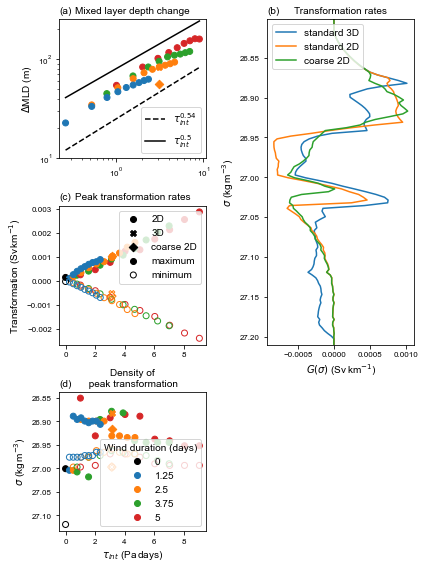

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(6, 8))

axs[0, 1].remove()
axs[1, 1].remove()
axs[2, 1].remove()
#axs[3, 1].remove()
#axs[3, 0].remove()
axbig = fig.add_subplot(3, 2, (2, 4))

plot_mld(axs[0, 0])
plot_transformation_rates(axs[1, 0])
plot_transformation_density(axs[2, 0])
plot_transformation_in_density_space(axbig)


axs[0, 0].set_title("Mixed layer depth change")
axbig.set_title("Transformation rates")
axs[1, 0].set_title("Peak transformation rates")
axs[2, 0].set_title("Density of\n peak transformation")

axs[0, 0].set_title("(a)", loc="left")
axbig.set_title("(b)", loc="left")
axs[1, 0].set_title("(c)", loc="left")
axs[2, 0].set_title("(d)", loc="left")


axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="o", label="2D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="X", label="3D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="D", label="coarse 2D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", label="maximum")
axs[1, 0].scatter(-np.inf, np.inf, color="k", facecolor="none", label="minimum")
axs[1, 0].legend()

axs[2, 0].scatter(-np.inf, np.inf, c="k", label="0")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:blue", label="1.25")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:orange", label="2.5")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:green", label="3.75")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:red", label="5")
axs[2, 0].legend(title="Wind duration (days)")

axs[0, 0].set_ylabel("$\\Delta$MLD (m)")
axs[1, 0].set_ylabel("Transformation (Sv$\,$km$^{-1}$)")
axs[2, 0].set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

axs[2, 0].set_xlabel("$\\tau_{int}$ (Pa$\,$days)")
axbig.set_xlabel("$G(\\sigma)$ (Sv$\,$km$^{-1}$)")
axbig.set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

fig.tight_layout()
fig.show()
fig.savefig(base_path / "figures/Mixing.pdf")

In [52]:
scluster.close()

2023-07-12 10:58:07,894 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-07-12 10:58:07,895 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2023-07-12 10:58:07,896 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2023-07-12 10:58:07,896 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2023-07-12 10:58:07,897 - distributed.nanny - WARNING - Worker process still alive after 3.19999984741211 seconds, killing
2023-07-12 10:58:07,897 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2023-07-12 10:58:07,898 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2023-07-12 10:58:07,898 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing


## The gradients of the line of best fit

In [22]:
mld_ensemble["tau_int"] = ds_ensemble["tau_int"]

In [31]:
ds_saved = mld_ensemble.to_dataset(name="delta_MLD")
ds_saved["transformation"] = transformation_ensemble
ds_saved["rho_upper"] = ensemble_class["rho_upper"]
ds_saved["rho_lower"] = ensemble_class["rho_lower"]
ds_saved["rho_intermediate"] = ensemble_class["rho_intermediate"]

In [33]:
ds_saved.to_zarr(base_path / "data/processed/transformation-calculations.zarr")

# Potential vorticity and stratification

In [7]:
no_slip_bottom = True
no_slip_sides = False
beta = 0
f0 = 1.26e-4

def process_dataset(ds):
    grid = pvcalc.create_xgcm_grid(ds)
    ds['drL'] = pvcalc.create_drL_from_dataset(ds)
    ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
    ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])

    grad_b = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)
    ds['db_dx'], ds['db_dy'], ds['db_dz'] = grad_b
    
    db_dz_mask = xr.where(grid.interp(ds['maskC'],
                                      ['Z'],
                                      to={'Z': 'right'},
                                      boundary='fill') == 0,
                          np.nan,
                          1)
    ds["maskN2"] = db_dz_mask
    ds['db_dz'] = ds['db_dz'] * db_dz_mask

    curl_vel = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                              ds['VVEL'],
                                              ds['WVEL'],
                                              ds,
                                              grid,no_slip_bottom,
                                              no_slip_sides)

    ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = curl_vel
    
    ds['NaNmaskC'] = xr.where(ds['maskC'] == 1, 1, np.NaN)
    
    ds['maskQ'] = grid.interp(ds['maskW'],
                              ['Y', 'Z'],
                              to={'Z': 'right', 'Y': 'left'},
                              boundary='fill')
    
    ds['NaNmaskQ'] = xr.where(ds['maskQ'] == 0, np.nan, 1)
    
    ds['Q'] = pvcalc.calculate_C_potential_vorticity(ds['zeta_x'],
                                                    ds['zeta_y'],
                                                    ds['zeta_z'],
                                                    ds['b'],
                                                    ds,
                                                    grid,
                                                    beta,
                                                    f0
                                                    ) * ds['NaNmaskQ']
    
    return ds, grid

In [9]:
interim_path = base_path / "data/interim"

ds_standard = xr.open_dataset(
    interim_path / "standard3DPVN2.nc",
)#.chunk({"time": 1, "XC": 75, "YC": 25})

ds_32 = xr.open_dataset(
    interim_path / "standard2DPVN2.nc"
)#.chunk({"time": 1, "XC": 2000, "YC": 1})

ds_coarse2d =xr.open_dataset(
    interim_path / "standardCoarsePVN2.nc"
)#.chunk({"time": 1, "XC": 750, "YC": 1})

In [6]:
interim_path = base_path / "data/interim"

ds_standard = xr.open_zarr(
    interim_path / "standard.zarr",
).chunk({"time": 1, "XC": 750, "YC": 500})

ds_32 = xr.open_zarr(
    interim_path / "run32.zarr"
).chunk({"time": 1, "XC": 2000, "YC": 1})

ds_coarse2d =xr.open_zarr(
    interim_path / "coarse-2d.zarr"
).chunk({"time": 1, "XC": 750, "YC": 1})

In [8]:
ds_standard = ds_standard.sel(
    time=[
        np.timedelta64(7, "D"), np.timedelta64(21, "D"), np.timedelta64(35, "D")
    ],
    method="nearest"
) 
ds_standard, grid3d = process_dataset(ds_standard)


ds_32 = ds_32.sel(
    time=[
        np.timedelta64(7, "D"), np.timedelta64(21, "D"), np.timedelta64(35, "D")
    ],
    method="nearest"
) 
ds_32, grid2d = process_dataset(ds_32)


ds_coarse2d = ds_coarse2d.sel(
    time=[
        np.timedelta64(7, "D"), np.timedelta64(14, "D"), np.timedelta64(28, "D")
    ],
    method="nearest"
)
ds_coarse2d, grid_coarse2d = process_dataset(ds_coarse2d)

In [9]:
ds_32

<xarray.Dataset>
Dimensions:   (YC: 1, XC: 6000, Z: 500, Zp1: 501, time: 3, XG: 6000, YG: 1,
               Zl: 500, Zu: 500)
Coordinates: (12/34)
    Depth     (YC, XC) float32 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(501,), meta=np.ndarray>
  * XC        (XC) float32 12.5 37.5 62.5 87.5 ... 1.499e+05 1.5e+05 1.5e+05
  * XG        (XG) float32 0.0 25.0 50.0 75.0 ... 1.499e+05 1.5e+05 1.5e+05
  * YC        (YC) float32 12.5
    ...        ...
    rA        (YC, XC) float32 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    rAs       (YG, XC) float32 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    rAw       (YC, XG) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    rAz       (YG, XG) float32 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    rhoRef    (Z) float32 dask.array<chunksize=(500,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 7 days 21 days 35 days
Data variables: (12/19)
    RHOAnoma  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    UVEL      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    WVEL      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    drL       (Zl) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    ...        ...
    zeta_y    (time, Zl, YC, XG) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    zeta_z    (time, Z, YG, XG) float32 dask.array<chunksize=(1, 500, 1, 2000), meta=np.ndarray>
    NaNmaskC  (Z, YC, XC) float64 dask.array<chunksize=(125, 1, 2000), meta=np.ndarray>
    maskQ     (Zl, YG, XG) bool dask.array<chunksize=(125, 1, 3000), meta=np.ndarray>
    NaNmaskQ  (Zl, YG, XG) float64 dask.array<chunksize=(125, 1, 3000), meta=np.ndarray>
    Q         (time, Zl, YG, XG) float64 dask.array<chunksize=(1, 125, 1, 2000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [10]:
drop_vars = list(ds_standard.variables)
drop_vars.remove("Q")
drop_vars.remove("db_dz")
drop_vars.remove("rho")
drop_vars.remove("XC")
drop_vars.remove("Zl")

ds_standard.drop(drop_vars)

<xarray.Dataset>
Dimensions:  (XC: 750, Zl: 500, time: 3, Z: 500, YC: 250, YG: 250, XG: 750)
Coordinates:
  * XC       (XC) float32 100.0 300.0 500.0 ... 1.495e+05 1.497e+05 1.499e+05
  * Zl       (Zl) float32 0.0 -1.0 -2.0 -3.0 ... -496.0 -497.0 -498.0 -499.0
Dimensions without coordinates: time, Z, YC, YG, XG
Data variables:
    rho      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    db_dz    (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 125, 250, 750), meta=np.ndarray>
    Q        (time, Zl, YG, XG) float64 dask.array<chunksize=(1, 125, 125, 188), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [11]:
ds_standard.drop(drop_vars).to_netcdf(interim_path / "standard3DPVN2.nc")
ds_32.drop(drop_vars).to_netcdf(interim_path / "standard2DPVN2.nc")
ds_coarse2d.drop(drop_vars).to_netcdf(interim_path / "standardCoarsePVN2.nc")

2023-08-03 15:46:37,635 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 1.61 GiB -- Worker memory limit: 2.00 GiB
2023-08-03 15:46:37,913 - distributed.worker.memory - WARNING - Worker is at 47% memory usage. Resuming worker. Process memory: 0.94 GiB -- Worker memory limit: 2.00 GiB
2023-08-03 15:46:40,031 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 1.61 GiB -- Worker memory limit: 2.00 GiB
2023-08-03 15:46:40,040 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 1.63 GiB -- Worker memory limit: 2.00 GiB
2023-08-03 15:46:40,159 - distributed.worker.memory - WARNING - Worker is at 45% memory usage. Resuming worker. Process memory: 0.92 GiB -- Worker memory limit: 2.00 GiB
2023-08-03 15:46:40,186 - distributed.worker.memory - WARNING - Worker is at 46% memory usage. Resuming worker. Process memory: 0.93 GiB -- Worker mem

## Generic plotting function

In [143]:
qlim = 2e-9
n2lim = 1e-5

cmo.curl.set_bad("grey")
cmo.tarn.set_bad("grey")

rho_contour = np.array([26.92, 26.98, 27.05, 27.12]) + 1000

def prepare_plotting_area():
    #fig = plt.figure(figsize=[6, 4])
    fig, axs = plt.subplots(
        figsize=[6, 5],
        nrows=3,
        ncols=4,
        height_ratios=[1, 1, 1/14],
        width_ratios=[1, 1, 1, 1/14],
        sharex=False,
        sharey=False,             
    )
    
    pv_axs = axs[0, :3]
    n2_axs = axs[1, :3]
    
    pv_cbax = axs[0, 3]
    n2_cbax = axs[1, 3]
    
    for i in range(3):
        pv_axs[i].set_xticklabels("")
        
    for i in range(1, 3):
        pv_axs[i].set_yticklabels("")
        n2_axs[i].set_yticklabels("")
        
    
    
    # gs = gridspec.GridSpec(2, 4,
    #                        height_ratios=[1, 1],
    #                        width_ratios=[1, 1, 1, 1/14])

    # pv_axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
    # n2_axs = [fig.add_subplot(gs[1, i]) for i in range(3)]
    # pv_cbax = fig.add_subplot(gs[0, 3])
    # n2_cbax = fig.add_subplot(gs[1, 3])

    pv_labels = ["(a)", "(b)", "(c)"]
    n2_labels = ["(d)", "(e)", "(f)"]

    for i in range(3):         
        pv_axs[i].set_ylim(250, 0)
        pv_axs[i].set_xlim(0, 100)
        n2_axs[i].set_ylim(250, 0)
        n2_axs[i].set_xlim(0, 100)

        pv_axs[i].set_title(pv_labels[i], loc="left")
        n2_axs[i].set_title(n2_labels[i], loc="left")

    n2_axs[1].set_xlabel("Longitude (km)", fontsize=8)
    fig.supylabel("Depth (m)", fontsize=8)
    
    
    contour_axs = axs[2, :]
    gs = contour_axs[0].get_gridspec()
    for ax in contour_axs:
        ax.remove()
    contour_axs = fig.add_subplot(gs[-1, :3])
    contour_axs.set_axis_off()

    return fig, pv_axs, n2_axs, pv_cbax, n2_cbax, contour_axs

In [144]:
def plot_pvn2(ds):
    fig, pv_axs, n2_axs, pv_cbax, n2_cbax, contour_axs = prepare_plotting_area()
    
    rho = ds["rho"].mean(dim="YC").load()
    Xrho = ds["XC"] * 1e-3
    Zrho = ds["Z"]

    N2 = ds["db_dz"].mean(dim="YC").load()
    Xn2 = ds["XC"] * 1e-3
    Zn2 = - ds["Zl"]

    Q = ds["Q"].mean(dim="YG").load()
    Xq = ds["XC"] * 1e-3
    Zq = - ds["Zl"]

    
    for i in range(3):
        cpv = pv_axs[i].pcolormesh(
            Xq,
            Zq,
            Q.isel(time=i),
            cmap=cmo.curl,
            vmin=-qlim,
            vmax=qlim,
            rasterized=True,
        )

        cn2 = n2_axs[i].pcolormesh(
            Xn2,
            Zn2,
            N2.isel(time=i),
            cmap=cmo.tarn,
            vmin=-n2lim,
            vmax=n2lim,
            rasterized=True,
        )

        cs = pv_axs[i].contour(
            Xrho,
            Zrho,
            rho.isel(time=i),
            levels=rho_contour,
            cmap=cmo.dense,
        )



        n2_axs[i].contour(
            Xrho,
            Zrho,
            rho.isel(time=i),
            levels=rho_contour,
            cmap=cmo.dense,
        )
        
    h1,l1 = cs.legend_elements()
    contour_axs.legend(
        h1, ["26.92", "26.98", 27.05, "27.12"],
        ncol=5,
        frameon=False,
        )
    
    
    fmt = ScalarFormatter(useMathText=True)
    pv_cb = fig.colorbar(cpv, pv_cbax, label="$Q$ (s$^{-3}$)", format=fmt)
    n2_cb = fig.colorbar(cn2, n2_cbax, label="$\\partial_z b$ (s$^{-2}$)", format=fmt)

    return fig, pv_axs, n2_axs

    


## Standard 3D

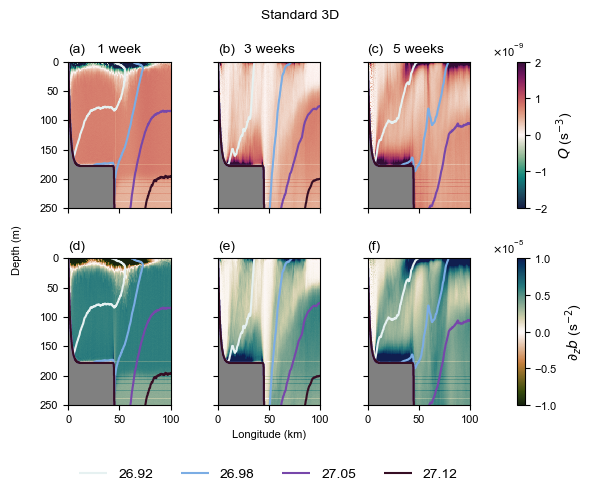

In [145]:
%matplotlib ipympl
fig, pv_axs, _ = plot_pvn2(ds_standard)

pv_axs[0].set_title("1 week")
pv_axs[1].set_title("3 weeks")
pv_axs[2].set_title("5 weeks")
fig.suptitle("Standard 3D")
    
fig.tight_layout()
fig.savefig(base_path / "reports/standard3D.pdf", dpi=400, transparent=True)

## Standard 2D

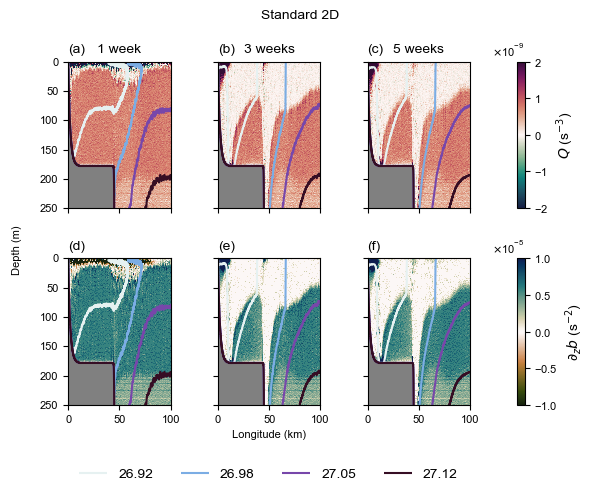

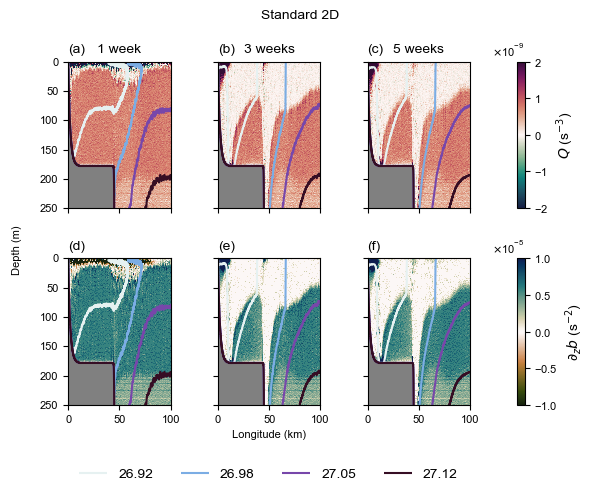

In [146]:
fig, pv_axs, _ = plot_pvn2(ds_32)

pv_axs[0].set_title("1 week")
pv_axs[1].set_title("3 weeks")
pv_axs[2].set_title("5 weeks")
    
fig.suptitle("Standard 2D")
    
fig.tight_layout()
fig.show()
fig.savefig(base_path / "reports/standard2D.pdf", dpi=400, transparent=True)

## Coarse 2D

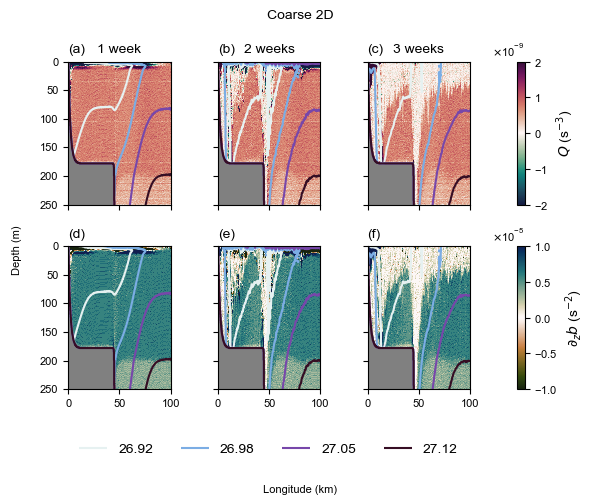

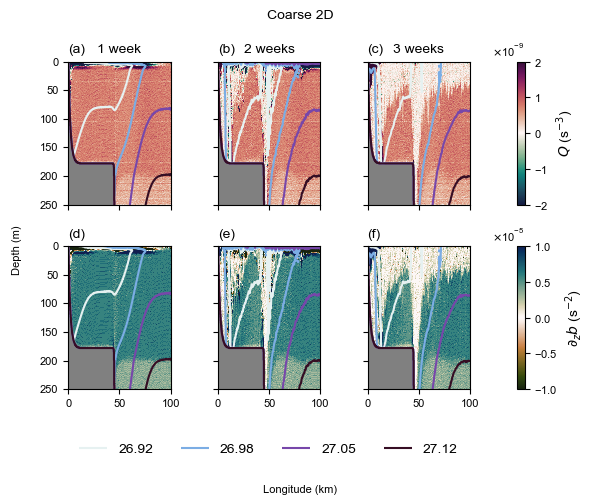

In [140]:
fig, pv_axs, _ = plot_pvn2(ds_coarse2d)

pv_axs[0].set_title("1 week")
pv_axs[1].set_title("2 weeks")
pv_axs[2].set_title("3 weeks")
    
fig.suptitle("Coarse 2D")
    
fig.tight_layout()
fig.show()

## Percentage of cells susceptible


In [147]:
ds_32 = xr.open_zarr(
    base_path / "data/interim/run32.zarr"
).chunk({"time": 1, "XC": 2000, "YC": 1})

ds_32, grid_32 = process_dataset(ds_32)

FileNotFoundError: No such file or directory: '/Users/frasergoldsworth/Projects/irminger-proj/data/interim/run32.zarr'

In [6]:
ds_32["time"] = ds_32["time"].astype("float32") * 1e-9

unstable_strat = xr.where(ds_32["db_dz"] < 0, 1, 0).sum("XC").transpose('Zl', 'time', ...)
unstable_strat = unstable_strat.compute() / ds_32["maskN2"].sum("XC")

unstable_pv = xr.where(ds_32["Q"] < 0, 1, 0).sum("XG").transpose("Zl", "time", ...)
unstable_pv = unstable_pv.compute() / ds_32["maskQ"].sum("XG")

NameError: name 'unstable_strat' is not defined

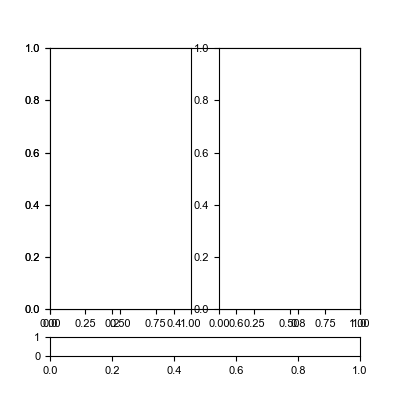

In [141]:
fig = plt.figure(figsize=(4, 4))


gs = gridspec.GridSpec(2, 2,
                    width_ratios=[1, 1],
                    height_ratios=[14, 1]
                    )

ax_xlab = fig.add_subplot(gs[0, :])
axs = [fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, :])]



cax = axs[0].pcolormesh(unstable_strat["time"] / 24 / 60 / 60,
                -unstable_strat["Zl"],
                unstable_strat.squeeze(),
                vmin=0,
                vmax=1,
                cmap=cmo.amp,
                rasterized=True)

axs[1].pcolormesh(unstable_pv["time"] / 24 / 60 / 60,
                -unstable_pv["Zl"],
                unstable_pv.squeeze(),
                vmin=0,
                vmax=1,
                cmap=cmo.amp,
                rasterized=True)

axs[1].set_yticklabels([])
axs[0].invert_yaxis()
axs[1].invert_yaxis()

ylim = 300
axs[0].set_ylim(ylim, 0)
axs[1].set_ylim(ylim, 0)

ax_xlab.set_xlabel("Time (days)", labelpad=18)
ax_xlab.set_yticks([])
ax_xlab.set_xticks([])

ax_xlab.spines['top'].set_visible(False)
ax_xlab.spines['right'].set_visible(False)
ax_xlab.spines['bottom'].set_visible(False)
ax_xlab.spines['left'].set_visible(False)

axs[0].set_title("$\\partial_z b < 0$", usetex=True)
axs[1].set_title("$fQ < 0$", usetex=True)

axs[0].set_title("(a)", loc="left")
axs[1].set_title("(b)", loc="left")


fig.suptitle("Regions of instability")

axs[0].set_ylabel("Depth (m)")

fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cb = fig.colorbar(cax, cax=axs[2],
                orientation="horizontal",
                label="Fraction of grid points",
                format=fmt)

fig.tight_layout()

figure_path = base_path / "reports"
fig.savefig(figure_path / "StandardInstabilityRegion.pdf", dpi=dpi, transparen=True)

In [17]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cycler
import matplotlib as mpl

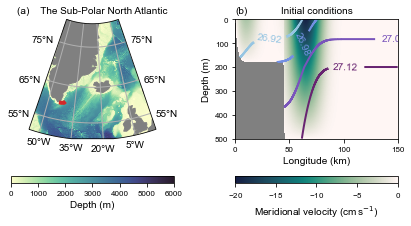

In [21]:

rho_levels = np.array([1026.92, 1026.98, 1027.05, 1027.1211])

# Open the datasats
raw_path = base_path / "data/raw"
gebco_path = raw_path / 'GEBCO-bathymetry-data/gebco_2022_n80.0_s50.0_w-55.0_e5.0.nc'
assert gebco_path.exists()

ds_bathymetry = xr.open_dataset(gebco_path)
ds_bathymetry = ds_bathymetry.coarsen(lon=5, lat=5, boundary='trim').mean()
ds_mooring_locs = xr.open_dataset(raw_path / 'CFall_finergrid_2m.nc')
ds_init = xr.open_zarr(
    base_path / "data/interim/run32.zarr"
).chunk({"time": 1, "XC": 2000, "YC": 1}).isel(time=0).squeeze()

ds_init["NaNmaskC"] = xr.where(ds_init["maskC"]==1, 1, np.NaN)
ds_init["rho"] = ds_init["RHOAnoma"] + ds_init["rhoRef"]

pad = 35
fig = plt.figure(figsize=(6, 3.25))

gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1],
                       height_ratios=[1, 1/16]
                       )

proj = ccrs.LambertConformal(central_longitude=-25,
                             #cutoff=50,
                             central_latitude=65)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

cax_bathy = ax1.pcolormesh(ds_bathymetry['lon'].values,
                           ds_bathymetry['lat'].values,
                           -ds_bathymetry['elevation'].values,
                           shading='nearest',
                           rasterized=True,
                           cmap=cmo.deep,
                           vmin=0,
                           vmax=6000,
                           transform=ccrs.PlateCarree()
                          )

xlim = [-55, 5]
ylim = [50, 80]
lower_space = 3 # this needs to be manually increased if the lower arch is cut off by changing lon and lat lims

rect = mpath.Path([[xlim[0], ylim[0]],
                [xlim[1], ylim[0]],
                [xlim[1], ylim[1]],
                [xlim[0], ylim[1]],
                [xlim[0], ylim[0]],
                ]).interpolated(20)

proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax1) - ax1.transData
rect_in_target = proj_to_data.transform_path(rect)

ax1.set_boundary(rect_in_target)
ax1.set_extent([xlim[0], xlim[1], ylim[0] - lower_space, ylim[1]])


ax1.add_feature(cfeature.NaturalEarthFeature('physical',
                                             'land',
                                             '110m',
                                             edgecolor='face',
                                             facecolor='grey'
                                            ))

ax1.plot(ds_mooring_locs['lon'],
            ds_mooring_locs['lat'][:-1],
            transform=ccrs.PlateCarree(),
            color='tab:red', lw=4)


gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,#draw_labels={"bottom": "x", 
                                            #            "left": "y"},
                   linewidth=1, linestyle='-', x_inline=False, 
                   y_inline=False, rotate_labels=False,
                   xlocs=[-50, -35, -20, -5, 10], ylocs=[55, 65, 75])

gl.top_labels = False
#gl.right_labels = False


# gl.xlocator = mticker.FixedLocator([-50, -35, -20, -5, 10])
# gl.ylocator = mticker.FixedLocator([55, 65, 75])
#gl.ylocator = LatitudeLocator()
#gl.xformatter = LongitudeFormatter()
#gl.yformatter = LatitudeFormatter()
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax1.set_title("(a)    The Sub-Polar North Atlantic")
#ax1.set_title("(a)", loc='left')
cbax1 = fig.add_subplot(gs[1, 0])
cb1 = plt.colorbar(cax_bathy,
                   cax=cbax1,
                   label='Depth (m)',
                   orientation='horizontal')

ax2 = fig.add_subplot(gs[0, 1])
cmo.tempo_r.set_bad('grey')

cax = ax2.pcolormesh(ds_init['XC'] * 1e-3,
                     -ds_init['Z'],
                     ds_init['VVEL'] * ds_init['NaNmaskC'] * 1e2,
                     vmin=-20,
                     vmax=0,
                     shading='nearest',
                     cmap=cmo.tempo_r,
                     rasterized=True)

n = 6
color = cmo.dense(np.linspace(0, 1, n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', ["C1", "C2", "C3", "C4", "C5"], 5)


CS = ax2.contour(ds_init['XC'] * 1e-3,
            -ds_init['Z'],
            ds_init['rho'] * ds_init['NaNmaskC'],
            levels=rho_levels,
            colors=["C1", "C2", "C3", "C4"],
            linewidths=2)

def fmt(x):
    sigma = x - 1000
    return rf"{sigma:.2f}" if plt.rcParams["text.usetex"] else f"{sigma:.2f}"

ax2.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
cbax = fig.add_subplot(gs[1, 1])
cb = plt.colorbar(cax,
                  cax=cbax,
                  label='Meridional velocity (cm$\,$s$^{-1}$)',
                  orientation='horizontal')

cb.formatter.set_useMathText(True)

ax2.set_xlabel("Longitude (km)")
ax2.set_ylabel("Depth (m)")
ax2.set_title("Initial conditions")
ax2.set_title("(b)", loc='left')

ax2.set_ylim(500, 0)

fig.tight_layout()
figure_path = base_path / "figures"
fig.savefig(figure_path / "EnsembleICsJGR.pdf", dpi=dpi)
